In [1]:
import numpy as np

from mushroom_hyperscanning.data import load_eeg

In [2]:
SUBJECT = "01"
CEREMONY = "ceremony1"
BIDS_ROOT = "../data/003_sanitization"

In [3]:
raw = load_eeg(SUBJECT, CEREMONY, root=BIDS_ROOT, preload=True)
raw.crop(tmax=60 * 20)  # use 20 minutes of data to test
raw.info

Extracting EDF parameters from /home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/data/003_sanitization/sub-01/ses-ceremony1/eeg/sub-01_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5612999  =      0.000 ... 18709.997 secs...


/home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/mushroom_hyperscanning/data.py:39: RuntimeWarning: The unit for channel(s) CM has changed from V to NA.
  raw.info.set_channel_types({ch: CH_TYPE_MAPPING[ch] if ch in CH_TYPE_MAPPING else "eeg" for ch in raw.ch_names})


<Info | 9 non-empty values
 bads: []
 ch_names: P3, C3, F3, Fz, F4, C4, P4, Cz, CM, A1, Fp1, Fp2, T3, T5, O1, ...
 chs: 21 EEG, 1 misc, 1 ECG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: 2024-11-07 21:54:13 UTC
 nchan: 23
 projs: []
 sfreq: 300.0 Hz
 subject_info: <subject_info | his_id: X, sex: 1, last_name: X, birthday: 2000-01-01>
>

Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).


/home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


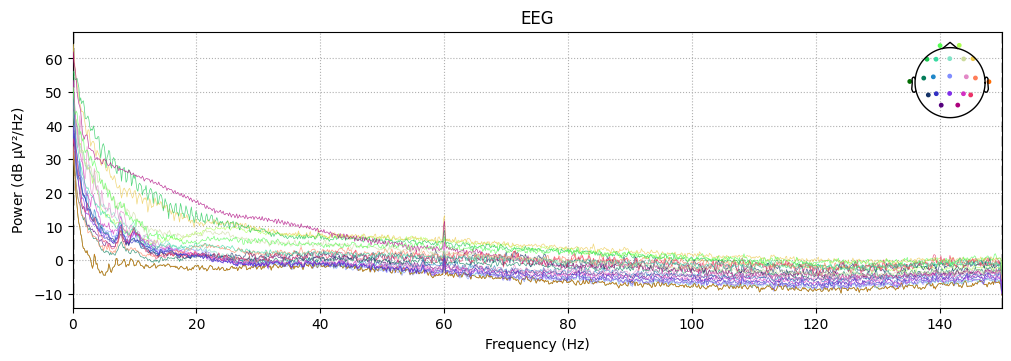

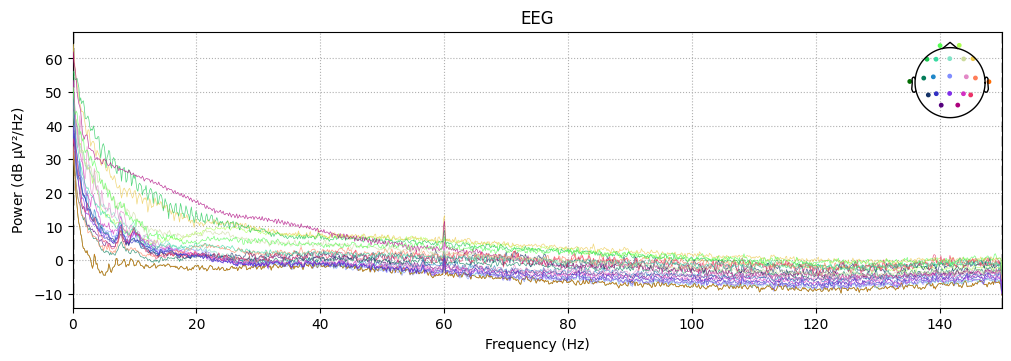

In [4]:
raw.compute_psd().plot()

In [5]:
from pyprep.prep_pipeline import PrepPipeline

# Fit prep
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(60, raw.info["sfreq"] / 2, 60),
}
raw_eeg = raw.copy().pick("eeg")

prep = PrepPipeline(raw_eeg, prep_params, raw_eeg.get_montage())
#prep.fit()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 991 samples (3.303 s)



Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished


Effective window size : 6.827 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished


Plotting power spectral density (dB=True).


/home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


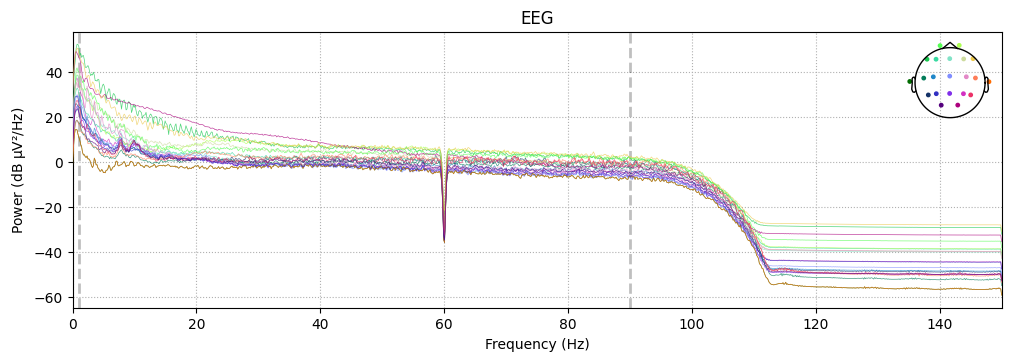

In [6]:
# Filter raw data
raw_filtered = raw.copy().filter(1, 90)
raw_filtered = raw_filtered.copy().notch_filter(np.arange(60, raw.info["sfreq"] / 2, 60))
raw_filtered.compute_psd().plot()

Not setting metadata
1200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1200 events and 300 original time points ...
0 bad epochs dropped


/home/hyruuk/GitHub/cocolab/mushroom_hyperscanning/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 21/21 [00:00<00:00,   30.65it/s]
100%|██████████| Computing thresholds ... : 21/21 [01:13<00:00,    3.50s/it]



















































































































































































































































































































































































































































































































































































































































































































































































































































































Estimated consensus=0.40 and n_interpolate=4


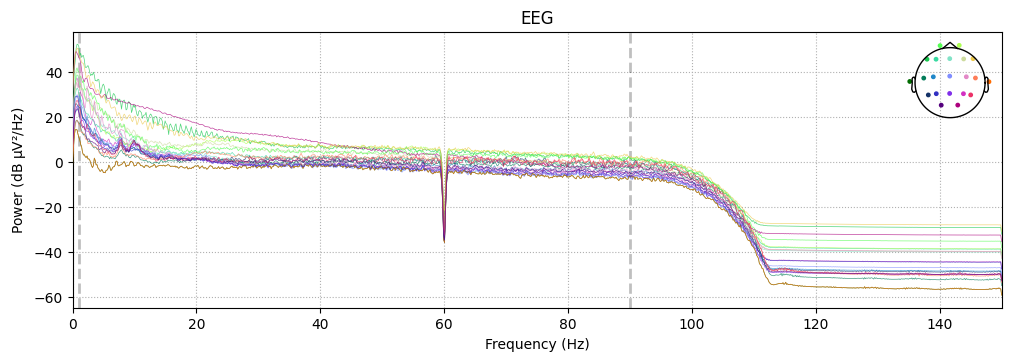

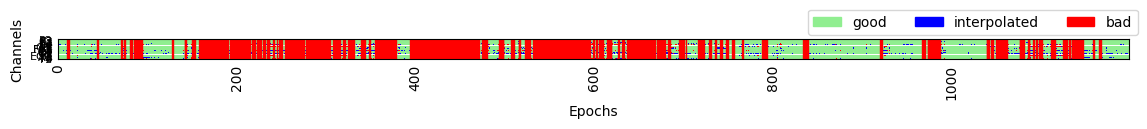

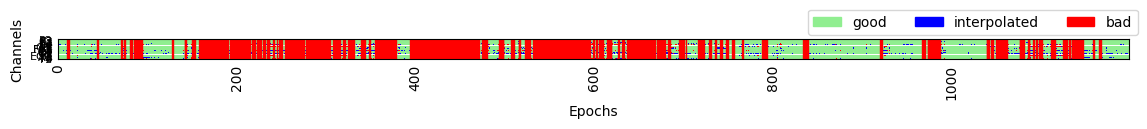

In [7]:
# Segment signals in 1s epochs
from mne import make_fixed_length_epochs
epochs = make_fixed_length_epochs(raw_filtered, duration=1.0, preload=True)

# Run a first autoreject before ICA
from autoreject import AutoReject
ar = AutoReject()
ar.fit(epochs)
arlog = ar.get_reject_log(epochs)

# plot autoreject results
arlog.plot('horizontal')

In [8]:
# Fit ICA without bad epochs
from mne.preprocessing import ICA
ica = ICA(n_components=15, random_state=69, max_iter='auto')
ica.fit(epochs[~arlog.bad_epochs])

Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,47 iterations on epochs (214200 samples)
ICA components,15
Available PCA components,21
Channel types,eeg
ICA components marked for exclusion,—


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 3000 samples (10.000 s)

Number of ECG events detected : 1433 (average pulse 71.64980097277508 / min.)
Not setting metadata
1433 matching events found
No baseline correction applied
Using data from preloaded Raw for 1433 events and 301 original time points ...
0 bad epochs dropped


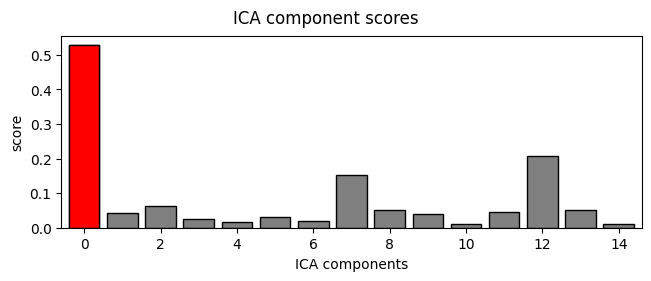

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1433 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1433 matching events found
No baseline correction applied
0 projection items activated


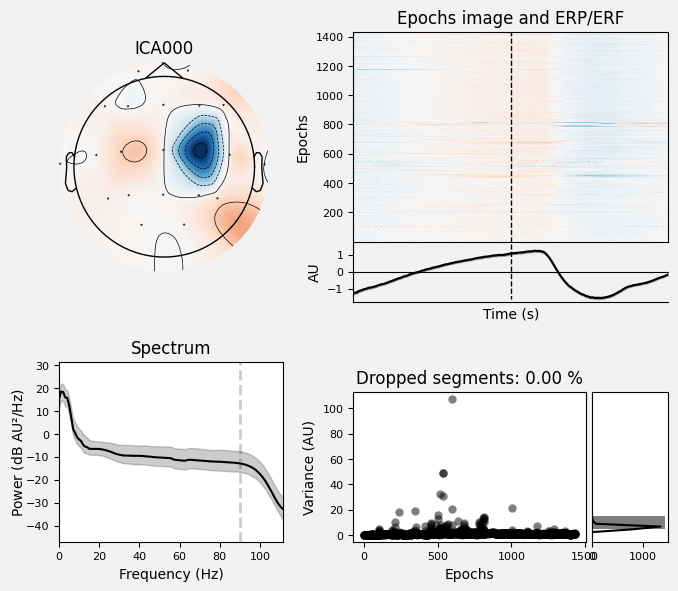

[<Figure size 700x600 with 6 Axes>]

In [9]:
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

## Find ECG components
ecg_threshold = 0.50
ecg_epochs = create_ecg_epochs(raw_filtered, ch_name="ECG")
ecg_inds, ecg_scores = ica.find_bads_ecg(
    ecg_epochs, ch_name="ECG", method="ctps", threshold=ecg_threshold
)
if ecg_inds == []:
    ecg_inds = [list(abs(ecg_scores)).index(max(abs(ecg_scores)))]

# Plot
ica.plot_scores(ecg_scores, exclude=ecg_inds)
ica.plot_properties(ecg_epochs, picks=ecg_inds)

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [10 11]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 3000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 20 significant peaks
Number of EOG events detected: 20
Not setting metadata
20 matching events found
No baseline correction applied
Using data from preloaded Raw for 20 events and 301 original time points ...
0 bad epochs dropped
Using EOG channels: Fp1,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


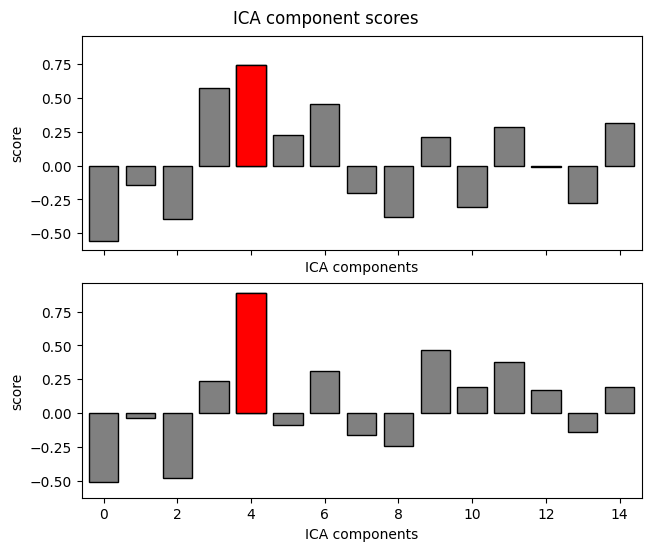

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


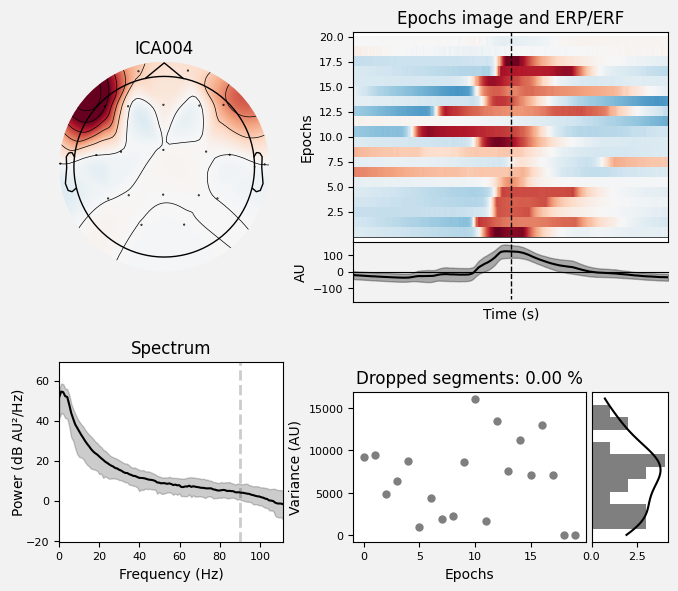

[<Figure size 700x600 with 6 Axes>]

In [10]:
## Find EOG components
eog_threshold = 2
eog_epochs = create_eog_epochs(raw_filtered, ch_name=["Fp1", "Fp2"])
eog_inds, eog_scores = ica.find_bads_eog(
    eog_epochs, ch_name=["Fp1", "Fp2"], threshold=eog_threshold
)

if eog_inds == []:
    eog_inds = [list(abs(eog_scores)).index(max(abs(eog_scores)))]

ica.plot_scores(eog_scores, exclude=eog_inds)
ica.plot_properties(eog_epochs, picks=eog_inds)

In [11]:
# Reconstruct raw without artifact components
ica.exclude = ecg_inds + eog_inds
raw_clean = raw_filtered.copy()
ica.apply(raw_clean)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components


<RawEDF | sub-01_ses-ceremony1_task-psilo_eeg.edf, 23 x 360001 (1200.0 s), ~63.2 MiB, data loaded>

Not setting metadata


1200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1200 events and 300 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 21/21 [00:00<00:00,   34.00it/s]
100%|██████████| Computing thresholds ... : 21/21 [01:10<00:00,    3.34s/it]



















































































































































































































































































































































































































































































































































































































































































































































































































































































Estimated consensus=0.60 and n_interpolate=4


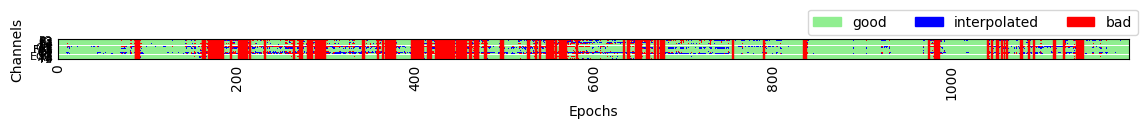

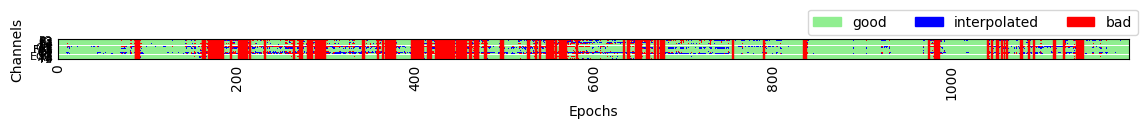

In [12]:
# Resegment and run autoreject on cleaned data
epochs_clean = make_fixed_length_epochs(raw_clean, duration=1.0, preload=True)
ar_clean = AutoReject()
ar_clean.fit(epochs_clean)
arlog_clean = ar_clean.get_reject_log(epochs_clean)
arlog_clean.plot('horizontal')